In [1]:
set.seed(42)

In [2]:
# credit for data cleaning: https://www.kaggle.com/gomes555/task2-covid-19-admission-ac-94-sens-0-92-auc-0-96 

In [3]:
library(data.table)
library(mltools)
library(sparseGraph)
library(spectralGraphTopology)
library(igraph)
library(scales)


Attaching package: ‘spectralGraphTopology’


The following object is masked from ‘package:stats’:

    D



Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Warning message:
“package ‘scales’ was built under R version 3.6.2”


In [4]:
library(janitor)      
library(ggplot2)      
library(readxl)       
library(dplyr)        
library(purrr)        
library(stringr)     
library(rsample)      
library(recipes)      
library(caret)        
library(DataExplorer) 
library(knitr)        
library(kableExtra)   
library(doParallel)   
library(DMwR)         
library(plotROC)      
library(pROC)         

theme_set(theme_bw())
cl <- makeCluster(8, outfile="")
registerDoParallel(cl)

dataset <- read_excel("brazil-covid-19-dataset.xlsx")

dataset <-
  dataset %>%
  clean_names() %>% 
  rowwise() %>%
  mutate( patient_addmited_to_all = sum(
    patient_addmited_to_regular_ward_1_yes_0_no,
    patient_addmited_to_semi_intensive_unit_1_yes_0_no,
    patient_addmited_to_intensive_care_unit_1_yes_0_no
  )) %>%
  ungroup() %>% 
  mutate(patient_addmited_to_all = if_else(patient_addmited_to_all == 1, 
                                           "positive", "negative")) %>% 
  filter(sars_cov_2_exam_result == "positive") %>% 
  select(-one_of(c('sars_cov_2_exam_result',
                   'patient_addmited_to_regular_ward_1_yes_0_no',
                   'patient_addmited_to_semi_intensive_unit_1_yes_0_no',
                   'patient_addmited_to_intensive_care_unit_1_yes_0_no')))

Warning message:
“package ‘janitor’ was built under R version 3.6.2”

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


Warning message:
“package ‘ggplot2’ was built under R version 3.6.2”
Warning message:
“package ‘dplyr’ was built under R version 3.6.2”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘purrr’ was built under R version 3.6.2”

Attaching package: ‘purrr’


The following object is masked from ‘package:scales’:

    discard


The following objects are masked from ‘package:igraph’:

    compose, simplify


The following object is masked from ‘package:data

In [5]:
treatment <- function(dataset){

dataset <- 
  dataset %>% 
  mutate_if(is.factor, as.character) %>% 
  janitor::clean_names() %>% 
  select(-one_of("patient_id"))

all_row_na <- 
  dataset %>% 
  select_if(~sum(is.na(.x)) == nrow(dataset)) %>% 
  colnames()

dataset <- dataset %>% select(-one_of(all_row_na))

all_cols_na <- 
  dataset %>% 
  select_if(~! sum(!is.na(.x)) == nrow(dataset)) %>% 
  { apply(., 1, function(x){sum(is.na(x))}) != ncol(.) } %>% 
  which()
dataset <- dataset %>% slice(all_cols_na)

dataset <- dataset %>%
  mutate_at('urine_p_h', ~as.numeric(ifelse(.x == "Não Realizado", NA, .x)))

urine_leuk_levels <- 
  table(dataset$urine_leukocytes) %>% names() %>% 
  str_replace("<1000", "0") %>% as.numeric() %>% sort()

dataset <- dataset %>% 
  mutate(urine_leukocytes = str_replace(urine_leukocytes, "<1000", "0") %>% 
           as.factor() %>% ordered(levels = urine_leuk_levels) %>% as.numeric())

dataset <- 
  dataset %>% 
  mutate_at(c('strepto_a',
              'urine_esterase', 
              'urine_hemoglobin',
              'urine_bile_pigments',
              'urine_ketone_bodies',
              'urine_protein'),
            ~ ifelse(.x == 'not_done', NA, .x))

dataset <- dataset %>% mutate_if(is.logical, as.numeric) 

num_card_mq10 <- 
  which( dataset %>% select_if(is.numeric) %>% map_dbl(~length(unique(.x))) < 10) %>% 
  names()
dataset <- dataset %>% select(-one_of(num_card_mq10))

dataset <- dataset %>% 
  mutate(urine_crystals = if_else(urine_crystals != "Ausentes", "other", "Ausentes")) 

dataset <- dataset %>% 
  mutate(urine_aspect = if_else(urine_aspect != "clear", "other", "clear")) 

dataset <- dataset %>% 
  mutate(urine_color = if_else(urine_color != "light_yellow", "other", "light_yellow")) 

dataset <- dataset %>% mutate_if(is.character, as.factor)

cat_um_nv <- 
  dataset %>% 
  select_if(~!is.numeric(.x)) %>%
  map_lgl(~length(levels(.x)) == 1) %>% which() %>% 
  names()

dataset <- dataset %>% select(-one_of(cat_um_nv))

return(dataset) 
}

In [6]:
dim(dataset)

[1] 558 108

In [7]:
dataset <- treatment(dataset)

In [8]:
dim(dataset)

[1] 182  57

In [9]:
head(dataset)

patient_age_quantile,hematocrit,hemoglobin,platelets,mean_platelet_volume,red_blood_cells,lymphocytes,mean_corpuscular_hemoglobin_concentration_mchc,leukocytes,basophils,⋯,creatine_phosphokinase_cpk,hb_saturation_arterial_blood_gases,p_co2_arterial_blood_gas_analysis,base_excess_arterial_blood_gas_analysis,p_h_arterial_blood_gas_analysis,total_co2_arterial_blood_gas_analysis,hco3_arterial_blood_gas_analysis,p_o2_arterial_blood_gas_analysis,ct_o2_arterial_blood_gas_analysis,patient_addmited_to_all
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
16,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,positive
10,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,negative
2,0.9918382,0.7921876,-0.34154767,1.4691876,1.6534758,-0.04838327,-0.4528995,-0.4201970,1.3035288,⋯,0.1254831,NA,NA,NA,NA,NA,NA,NA,NA,negative
15,-0.4959191,-0.3982758,-0.71840197,-0.4380969,-0.5679496,-0.93540388,0.2441486,-0.8209189,-1.1401438,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,positive
14,-0.3128107,-0.6489002,-0.02750243,-0.1015171,-0.6561009,-0.09955740,-1.4486814,-0.9684070,-0.5292256,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,negative
9,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,negative


In [10]:
labels <- dataset[ncol(dataset)]

In [11]:
labels_num <- matrix(as.numeric(unlist(labels)), nrow = nrow(dataset))

In [12]:
dataset <- dataset[, -ncol(dataset)]

In [13]:
head(dataset)

patient_age_quantile,hematocrit,hemoglobin,platelets,mean_platelet_volume,red_blood_cells,lymphocytes,mean_corpuscular_hemoglobin_concentration_mchc,leukocytes,basophils,⋯,lactic_dehydrogenase,creatine_phosphokinase_cpk,hb_saturation_arterial_blood_gases,p_co2_arterial_blood_gas_analysis,base_excess_arterial_blood_gas_analysis,p_h_arterial_blood_gas_analysis,total_co2_arterial_blood_gas_analysis,hco3_arterial_blood_gas_analysis,p_o2_arterial_blood_gas_analysis,ct_o2_arterial_blood_gas_analysis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
16,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
10,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,0.9918382,0.7921876,-0.34154767,1.4691876,1.6534758,-0.04838327,-0.4528995,-0.4201970,1.3035288,⋯,-0.6207166,0.1254831,NA,NA,NA,NA,NA,NA,NA,NA
15,-0.4959191,-0.3982758,-0.71840197,-0.4380969,-0.5679496,-0.93540388,0.2441486,-0.8209189,-1.1401438,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
14,-0.3128107,-0.6489002,-0.02750243,-0.1015171,-0.6561009,-0.09955740,-1.4486814,-0.9684070,-0.5292256,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
9,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [14]:
data_mat <- t(matrix(as.numeric(unlist(dataset)), nrow = nrow(dataset)))

In [15]:
data_mat[is.na(data_mat)] <- 0

In [16]:
dim(data_mat)

[1]  56 182

In [17]:
S <- cor(data_mat)
p <- nrow(S)

In [18]:
dim(S)

[1] 182 182

In [19]:
graph_scad <- learn_laplacian_pgd_connected(S + diag(1/10, p, p),
                                            alpha = 1e-1, sparsity_type = "scad", gamma = 2.01,
                                            verbose = FALSE, maxiter = 1000)

In [20]:
graph_scad$elapsed_time[length(graph_scad$elapsed_time)]

elapsed 
 25.042

In [21]:
.5 * sum(graph_scad$adjacency > 0)

[1] 1565

In [22]:
graph_mcp <- learn_laplacian_pgd_connected(S + diag(1/10, p, p),
                                           alpha = 5e-1, sparsity_type = "mcp", gamma = 1.01,
                                           verbose = FALSE, maxiter = 1000)

In [23]:
.5 * sum(graph_mcp$adjacency > 0)

[1] 525

In [24]:
graph_mcp$elapsed_time[length(graph_mcp$elapsed_time)]

elapsed 
 24.389

In [25]:
graph_admm <- learn_laplacian_gle_admm(S + diag(1/10, p, p), record_objective = TRUE,
                                      verbose = FALSE, maxiter = 2000)

In [26]:
graph_admm$elapsed_time[length(graph_admm$elapsed_time)]

elapsed 
  9.307

In [29]:
.5 * sum(graph_admm$adjacency > 0)

[1] 11395

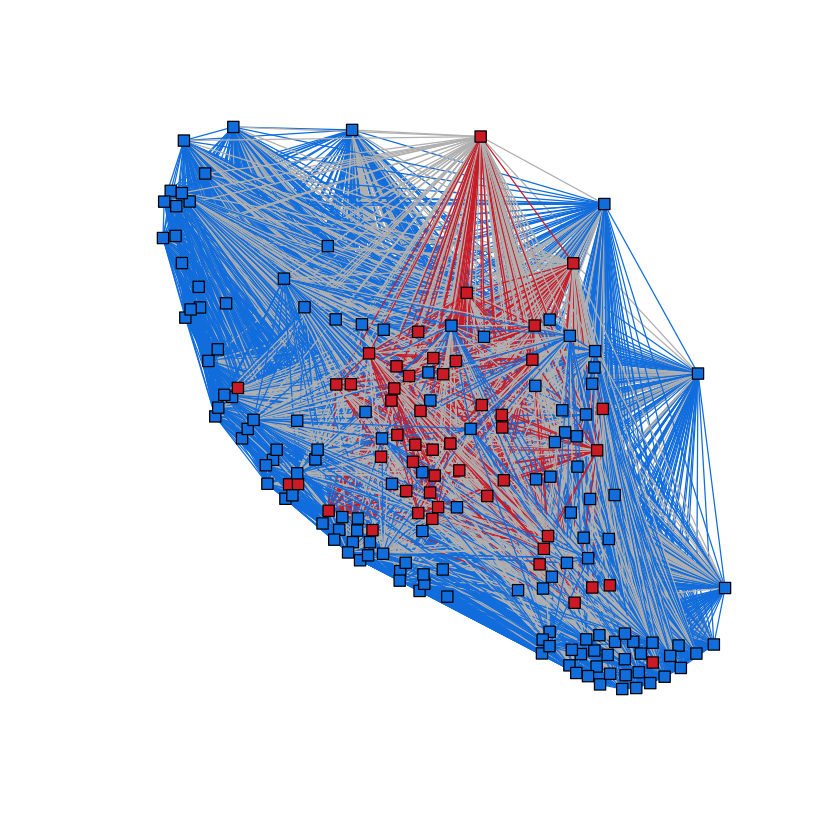

In [31]:
net <- graph_from_adjacency_matrix(graph_admm$adjacency, mode = "undirected", weighted = TRUE)
la_true <- layout_nicely(net)
colors <- c("#0984e3", "#d63031")
V(net)$cluster <- labels_num
E(net)$color <- apply(as.data.frame(get.edgelist(net)), 1,
                     function(x) ifelse(V(net)$cluster[x[1]] == V(net)$cluster[x[2]],
                                        colors[V(net)$cluster[x[1]]], "grey"))
V(net)$color <- colors[labels_num]
plot(net, layout = la_true,
     vertex.label = NA, vertex.size = 4, vertex.shape = 'square')

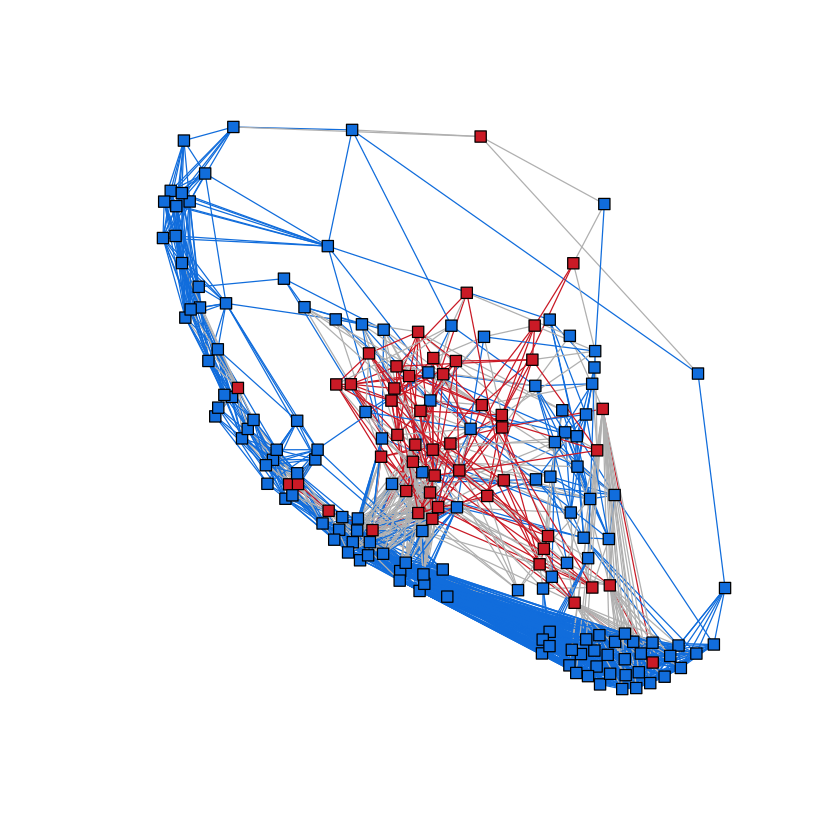

In [32]:
net <- graph_from_adjacency_matrix(graph_scad$adjacency, mode = "undirected", weighted = TRUE)
V(net)$cluster <- labels_num
E(net)$color <- apply(as.data.frame(get.edgelist(net)), 1,
                     function(x) ifelse(V(net)$cluster[x[1]] == V(net)$cluster[x[2]],
                                        colors[V(net)$cluster[x[1]]], "grey"))
V(net)$color <- colors[labels_num]
plot(net, layout = la_true,
     vertex.label = NA, vertex.size = 4, vertex.shape = 'square')

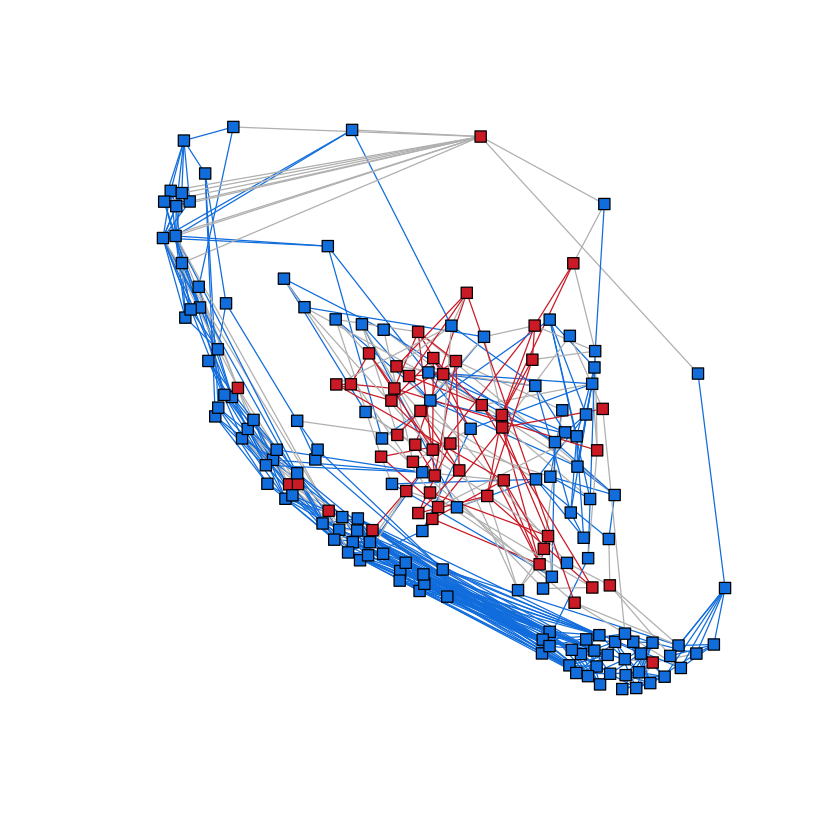

In [33]:
net <- graph_from_adjacency_matrix(graph_mcp$adjacency, mode = "undirected", weighted = TRUE)
V(net)$cluster <- labels_num
E(net)$color <- apply(as.data.frame(get.edgelist(net)), 1,
                     function(x) ifelse(V(net)$cluster[x[1]] == V(net)$cluster[x[2]],
                                        colors[V(net)$cluster[x[1]]], "grey"))
V(net)$color <- colors[labels_num]
plot(net, layout = la_true,
     vertex.label = NA, vertex.size = 4, vertex.shape = 'square')